In [6]:
import numpy as np
import networkx as nx
from scipy import stats
import matplotlib.pyplot as plt
from tqdm import tqdm


def power_law_with_exponential_cutoff(
        exponent: float, mean: float, size: int):
    x_min = mean*(exponent - 2)/(exponent - 1)
    return x_min*np.power((1 - stats.uniform.rvs(size=size)), 1/(1 - exponent))

def discrete_power_law(b, xmin, xmax, size=1):
    u = np.random.uniform(low=0, high=1, size=size)
    samples = xmin / (u ** (1 / b))
    samples = np.clip(samples, a_min=None, a_max=xmax)
    discrete_samples = np.round(samples).astype(int)    
    return discrete_samples

def zipfian_degrees(exponent: float, x_min: int, x_max: int, size: int):
    return stats.zipfian.rvs(size=size, a=exponent-1, n=x_max-x_min, loc=x_min)

def ba_adj(nodes, k=64):
    while not nx.is_connected(net := nx.barabasi_albert_graph(
            nodes, k//2)):
        pass

    adj = nx.to_scipy_sparse_array(net, format="lil")
    for i in range(nodes):
        adj[i, i] = 1
    return adj

def reg_adj(nodes, k=64):
    while not nx.is_connected(net := nx.random_regular_graph(
            k, nodes)):
        pass

    adj = nx.to_scipy_sparse_array(net, format="lil")
    for i in range(nodes):
        adj[i, i] = 1
    return adj


def er_adj(nodes, k=64):
    while not nx.is_connected(net := nx.fast_gnp_random_graph(
            nodes, k/(nodes-1))):
        pass

    adj = nx.to_scipy_sparse_array(net, format="lil")
    for i in range(nodes):
        adj[i, i] = 1
    return adj


def power_law_adj(nodes, exponent, k=64):
    ds = power_law_with_exponential_cutoff(exponent=exponent, mean=k, size=nodes)
    # ds = discrete_power_law(b=exponent-1, xmin=k*3, xmax=nodes, size=nodes)
    while not nx.is_connected(net := nx.expected_degree_graph(
            ds, selfloops=False)):
        pass

    adj = nx.to_scipy_sparse_array(net, format="lil")
    for i in range(nodes):
        adj[i, i] = 1
    return adj

def run_iterations(
        adj, noise=1e-3, params=20, rounds=40, gain=1.0,
        bounds=5.0):
    adj = adj.copy()
    nodes = adj.shape[0]
    state = np.random.uniform(-bounds*gain, +bounds*gain, size=(nodes, params))

    initial_stds = np.std(state, axis=1)[:, np.newaxis]

    adj /= np.sum(adj, axis=1)[:, np.newaxis]
    noise = stats.norm(loc=0, scale=noise)

    stds_across_params = []
    for i in (tqdm(range(rounds)) if rounds > 200 else range(rounds)):
        stds_across_params.append(np.mean(np.std(state, axis=1)))

        state = adj @ state + noise.rvs(state.shape)
    return stds_across_params

 20%|██        | 1/5 [03:32<14:11, 212.91s/it]

2.5 -0.30310094660260845


 40%|████      | 2/5 [07:28<11:18, 226.04s/it]

3.0 -0.4030387157951433


 60%|██████    | 3/5 [11:23<07:40, 230.28s/it]

3.5 -0.4539193132592137


 80%|████████  | 4/5 [14:58<03:44, 224.31s/it]

4.0 -0.47591490794447344


100%|██████████| 5/5 [18:37<00:00, 223.43s/it]

5.0 -0.4894840306167286


BA -0.4339198628689975
ER -0.49231559817679965
Regular -0.49298429256662873


Text(0, 0.5, 'Scaling factor exponent')

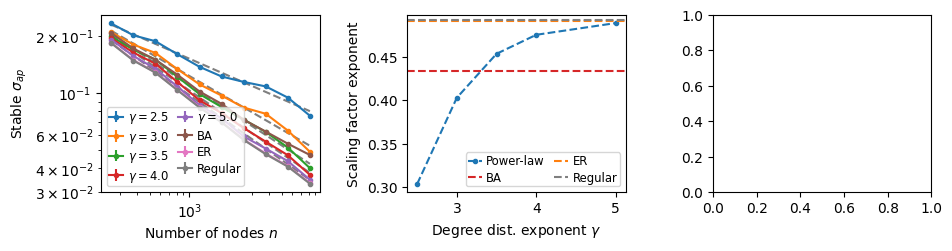

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
from tqdm import tqdm
import concurrent.futures

def run_power_law_simulation(n, e):
    adj = power_law_adj(nodes=n, exponent=e)
    ap = run_iterations(adj, params=200, noise=1e-3)
    return ap

def run_ba_simulation(n):
    adj = ba_adj(nodes=n)
    ap = run_iterations(adj, params=200, noise=1e-3)
    return ap

def run_er_simulation(n):
    adj = er_adj(nodes=n)
    ap = run_iterations(adj, params=200, noise=1e-3)
    return ap

def run_reg_simulation(n):
    adj = reg_adj(nodes=n)
    ap = run_iterations(adj, params=200, noise=1e-3)
    return ap

def run_ensemble_simulations(n, e, simulation_function, power_law=False, ens=2):
    with concurrent.futures.ProcessPoolExecutor(max_workers=64) as executor:
        if power_law:
            results = list(executor.map(simulation_function, [n]*ens, [e]*ens))
        else:
            results = list(executor.map(simulation_function, [n]*ens))
    return results

fig, (ax, ax2, ax3) = plt.subplots(
    ncols=3, figsize=(8.3, 2.3),
    gridspec_kw=dict(wspace=0.4, left=0.0, right=1.0))

exponents = [2.5, 3.0, 3.5, 4.0, 5.0]
ns = [int(n) for n in np.geomspace(2**8, 2**13, num=10)]
slopes = []

ens = 128

for e in tqdm(exponents):
    aps = []
    for n in ns:
        ens_aps = run_ensemble_simulations(n, e, run_power_law_simulation, power_law=True, ens=ens)
        aps.append(ens_aps)
    ax.errorbar(ns, np.mean(aps, axis=1)[:, -1],
                yerr=1.96*np.std(aps, axis=1)[:, -1]/np.sqrt(ens),
                marker='.', label=f"$\\gamma={e}$")
    log_ns = np.log(ns)
    log_means = np.log(np.mean(aps, axis=1)[:, -1])
    slope, intercept, r_value, p_value, std_err = linregress(log_ns, log_means)
    print(e, slope)
    slopes.append(slope)
    fitted_line = np.exp(intercept + slope * log_ns)
    ax.plot(ns, fitted_line, linestyle='--', color="tab:grey")

ax2.plot(exponents, -np.array(slopes), ls='--', marker='.', label=f"Power-law")

aps = []
for n in ns:
    ens_aps = run_ensemble_simulations(n, None, run_ba_simulation, ens=ens)
    aps.append(ens_aps)
ax.errorbar(ns, np.mean(aps, axis=1)[:, -1],
            yerr=1.96*np.std(aps, axis=1)[:, -1]/np.sqrt(ens),
            marker='.', label=f"BA")
log_ns = np.log(ns)
log_means = np.log(np.mean(aps, axis=1)[:, -1])
slope, intercept, r_value, p_value, std_err = linregress(log_ns, log_means)
ax2.axhline(-slope, label="BA", ls='--', color="tab:red")
print("BA", slope)

aps = []
for n in ns:
    ens_aps = run_ensemble_simulations(n, None, run_er_simulation, ens=ens)
    aps.append(ens_aps)
ax.errorbar(ns, np.mean(aps, axis=1)[:, -1],
            yerr=1.96*np.std(aps, axis=1)[:, -1]/np.sqrt(ens),
            marker='.', label=f"ER")
log_ns = np.log(ns)
log_means = np.log(np.mean(aps, axis=1)[:, -1])
slope, intercept, r_value, p_value, std_err = linregress(log_ns, log_means)
ax2.axhline(-slope, label="ER", ls='--', color="tab:orange")
print("ER", slope)

aps = []
for n in ns:
    ens_aps = run_ensemble_simulations(n, None, run_reg_simulation, ens=ens)
    aps.append(ens_aps)
ax.errorbar(ns, np.mean(aps, axis=1)[:, -1],
            yerr=1.96*np.std(aps, axis=1)[:, -1]/np.sqrt(ens),
            marker='.', label=f"Regular")
log_ns = np.log(ns)
log_means = np.log(np.mean(aps, axis=1)[:, -1])
slope, intercept, r_value, p_value, std_err = linregress(log_ns, log_means)
ax2.axhline(-slope, label="Regular", ls='--', color="tab:grey")
print("Regular", slope)

ax.set_xscale("log")
ax.set_yscale("log")
ax.legend(fontsize="small",
          ncols=2, borderpad=0.2, labelspacing=0.3,
          handlelength=1.2, handletextpad=0.4,
          columnspacing=0.8)
ax.set_ylabel("Stable $\\sigma_{ap}$")
ax.set_xlabel("Number of nodes $n$")

ax2.legend(fontsize="small",
           ncols=2, borderpad=0.2, labelspacing=0.3,
           handlelength=1.2, handletextpad=0.4,
           columnspacing=0.8)
ax2.set_xlabel("Degree dist. exponent $\\gamma$")
ax2.set_ylabel("Scaling factor exponent")

In [59]:
a = np.array(aps)[:, :, -1]
2*np.std(a, axis=-1)

array([2.02262079e-08, 2.12869436e-08, 1.62233092e-08, 1.69034002e-08,
       1.68390041e-08, 1.50419113e-08, 1.68278565e-08, 1.45074728e-08,
       1.85361830e-08, 1.47311743e-08])

In [58]:
fig.savefig("fig5.pdf", bbox_inches="tight")

261.2421875


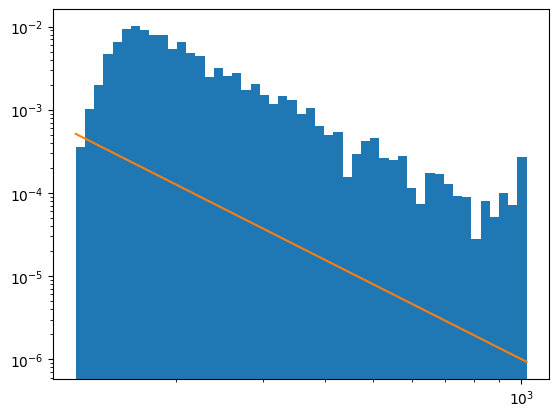

In [45]:
e = 3.0
adj = power_law_adj(nodes=2**10, exponent=e, k=300)
degs = np.sum(adj, axis=1)
plt.hist(degs, bins=np.geomspace(min(degs), max(degs)+1), density=True)
plt.xscale("log")
plt.yscale("log")
plt.plot(np.geomspace(min(degs), max(degs)+1), 1e3*np.geomspace(min(degs), max(degs)+1)**-e)
print(np.mean(degs-1))

In [36]:
2**9

512

In [8]:
import networkx as nx
from pathlib import Path
import numpy as np
from concurrent.futures import ProcessPoolExecutor
import os

def process_file(f):
    g = nx.read_edgelist(f)
    if g.number_of_edges() > 0:
        adj = nx.to_numpy_array(g) + np.eye(g.number_of_nodes())
        adj /= adj.sum(axis=1, keepdims=True)
        vals, vecs = np.linalg.eig(adj.T)
        idx = np.argmax(vals)
        gain = np.abs(np.sum(vecs[:, idx]))
        return gain
    return None

def process_r_value(r):
    files = list(Path("../networks/er-rewired/").glob(f"nodes-2048-degree-8-r-{r}-seed-*.edges"))
    with ProcessPoolExecutor(max_workers=32) as executor:
        results = list(executor.map(process_file, files))
    return [result for result in results if result is not None]

rs = ["-0.8", "-0.7", "-0.6", "-0.5", "-0.4", "-0.3", "-0.2", "-0.1", "0.0", "0.1", "0.2", "0.3", "0.4", "0.5", "0.6", "0.7", "0.8"]
vs = []
with ProcessPoolExecutor() as executor:
    results = list(executor.map(process_r_value, rs))
vs = results
rs = [float(r) for r in rs]

In [9]:
def process_original_nets():
    files = list(Path("../networks/er/").glob(f"nodes-2048-degree-8-seed-*.edges"))
    with ProcessPoolExecutor(max_workers=256) as executor:
        results = list(executor.map(process_file, files))
    return [result for result in results if result is not None]

raw_vs = process_original_nets()

In [16]:
import matplotlib.pyplot as plt

ax3.errorbar(
    rs, [np.mean(v) for v in vs],
    yerr=[1.96*np.std(v)/len(v)**0.5 for v in vs],
    label="Rewired fixed \nassortativity network")

ax3.axhline(
    np.mean(raw_vs), ls="--",color="tab:gray",
    label="Original network")
ax3.set_ylabel("$\\left|| v_\\text{steady} \\right||$")
ax3.set_xlabel("Degree assortativity $\\rho$")
ax3.set_ylim(43.10, 43.3)
ax3.set_xlim(-1, 1)
ax3.legend(fontsize="small",
           borderpad=0.2, labelspacing=0.3,
           handlelength=1.2, handletextpad=0.4,
           columnspacing=0.8)

In [18]:
ax.text(-0.1, 1.05, "(a)",
         transform=ax.transAxes)
ax2.text(-0.1, 1.05, "(b)",
         transform=ax2.transAxes)
ax3.text(-0.1, 1.05, "(c)",
         transform=ax3.transAxes)

Text(-0.1, 1.05, '(c)')

In [20]:
fig.savefig("fig5_3_panel.pdf", bbox_inches="tight")